In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# import required packages
import pandas as pd
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split

# models
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 

# metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import recall_score, roc_auc_score

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
# load the cleaned and preprocessed data sets
df_train = pd.read_csv('../data/train.csv')
df_valid = pd.read_csv('../data/valid.csv')
df_test = pd.read_csv('../data/test.csv')

# include validation set into train set
df_train = pd.concat([df_train, df_valid]).sample(frac=1, random_state=42).reset_index(drop=True)

# shape of the train and test sets: (rows, columns)
display(df_train.shape, df_test.shape)

(69767, 78)

(17442, 78)

In [7]:
# first 5 datapoints of train, validation and test sets
display(df_train.head())
display(df_test.head())

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_equal_url,qty_at_url,qty_and_url,qty_comma_url,qty_plus_url,qty_asterisk_url,...,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_shortened,phishing
0,1,0,1,3,0,0,0,0,0,0,...,7404,264,1,4,2,1411,1,1,0,0
1,3,1,0,4,0,0,0,0,0,0,...,-1,-1,1,2,1,281,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,7372,662,1,2,1,14398,1,0,0,0
3,14,1,0,5,3,0,8,0,0,0,...,235,129,1,2,1,7764,1,0,0,1
4,2,0,0,1,0,0,0,0,0,0,...,648,81,1,2,1,14391,1,0,0,1


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_equal_url,qty_at_url,qty_and_url,qty_comma_url,qty_plus_url,qty_asterisk_url,...,time_domain_activation,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_shortened,phishing
0,3,0,0,2,1,0,0,0,0,0,...,6007,201,1,3,1,288,0,0,0,0
1,2,0,1,2,0,0,0,0,0,0,...,1126,334,2,2,0,591,0,5,0,1
2,3,0,0,1,0,0,0,0,0,0,...,5820,626,1,2,1,14393,1,1,0,1
3,2,1,0,3,0,0,0,0,0,0,...,3066,220,1,2,2,594,0,0,0,1
4,2,0,2,1,0,0,0,0,0,0,...,4023,359,3,2,0,298,0,0,0,1


0    45369
1    24398
Name: phishing, dtype: int64


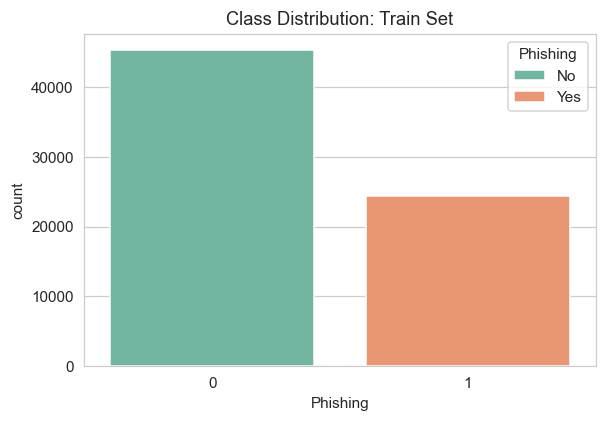

In [8]:
# class distribution
print(df_train['phishing'].value_counts())

# plot the class distribution
plt.figure(dpi=110)

chart = sns.countplot(x='phishing', data=df_train, hue='phishing', dodge=False, palette='Set2')

axes = chart.axes
axes.set_title('Class Distribution: Train Set')
axes.set_xlabel('Phishing')
axes.legend(['No', 'Yes'], title='Phishing')

plt.show()

In [9]:
# separate datasets into independent and dependent features: x & y
# maintain scaled version of the dataset for logistic regression & svm
# train set
X_train = df_train.drop('phishing', axis=1)
y_train = df_train['phishing']

# test set
X_test = df_test.drop('phishing', axis=1)
y_test = df_test['phishing']

In [10]:
# utility function
# plot confusion matrix using sns heatmap
def plot_confusion_matrix(cf_matrix, title, xlabel='Predicted', ylabel='Actual', ticklabels=None, figsize=(8,4), fontdict={'fontsize':12}):
    
    # extract counts from confusion matrix
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    # calculate proportions from confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    # create annotations for plot
    annotations = [f'{count}\n{percentage}\n'.format(count, percentage) for count, percentage in zip(group_counts, group_percentages)]
    annotations = np.asarray(annotations).reshape(cf_matrix.shape)

    plt.figure(figsize = figsize, dpi=100)
    ax = sns.heatmap(cf_matrix, annot=annotations, fmt='', cmap='Blues')

    # set title
    ax.set_title(title, fontdict=fontdict)
    
    # set axes labels
    ax.set_xlabel(xlabel, fontdict=fontdict)
    ax.set_ylabel(ylabel, fontdict=fontdict)

    # tick labels - List must be in alphabetical order
    if ticklabels:
        # set axes tick labels
        ax.xaxis.set_ticklabels(ticklabels)
        ax.yaxis.set_ticklabels(ticklabels)

    # display the visualization of the confusion matrix.
    plt.show()

In [11]:
# create a map of params to be optimized
params = {
    'learning_rate': (0.03, 0.1, 0.3),
    'max_depth': (4, 6, 8, 10),
    'n_estimators': (50, 100, 500)
}

# instantiate a GridSearchCV object with SVM model and params
grid_search_cv = GridSearchCV(XGBClassifier(), params, scoring = 'roc_auc', verbose=4, cv=5)

# perform grid search
grid_search_cv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.03, max_depth=4, n_estimators=50; total time=   2.0s
[CV 2/5] END learning_rate=0.03, max_depth=4, n_estimators=50; total time=   1.8s
[CV 3/5] END learning_rate=0.03, max_depth=4, n_estimators=50; total time=   1.8s
[CV 4/5] END learning_rate=0.03, max_depth=4, n_estimators=50; total time=   1.8s
[CV 5/5] END learning_rate=0.03, max_depth=4, n_estimators=50; total time=   1.8s
[CV 1/5] END learning_rate=0.03, max_depth=4, n_estimators=100; total time=   3.5s
[CV 2/5] END learning_rate=0.03, max_depth=4, n_estimators=100; total time=   3.5s
[CV 3/5] END learning_rate=0.03, max_depth=4, n_estimators=100; total time=   3.7s
[CV 4/5] END learning_rate=0.03, max_depth=4, n_estimators=100; total time=   3.5s
[CV 5/5] END learning_rate=0.03, max_depth=4, n_estimators=100; total time=   3.5s
[CV 1/5] END learning_rate=0.03, max_depth=4, n_estimators=500; total time=  17.1s
[CV 2/5] END learning_rate=0.0

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [12]:
# display the best parameters for XGBoost and the best score
grid_search_cv.best_params_, grid_search_cv.best_score_

({'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500},
 0.9956443232320717)

In [13]:
# instantiate XGBClassifier with best parameters
model = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.1,)

# training start
print('training...')
start_time = time.time()

# train the model
model.fit(X_train, y_train)

# training end
end_time = time.time()
time_to_train = end_time - start_time
print('training completed:', '{:.2f}'.format(time_to_train), 'seconds')

# testing start
print('testing...')
start_time = time.time()

# evaluate the model on test set
y_pred = model.predict(X_test)

# testing end
end_time = time.time()
print('testing completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training...
training completed: 70.01 seconds
testing...
testing completed: 0.13 seconds


accuracy 0.9739708748996675
recall 0.9608132480734547
f1-score 0.9627074092327912
roc_auc 0.9709294134222515


,F1 Score
0,0.980009
1,0.962707


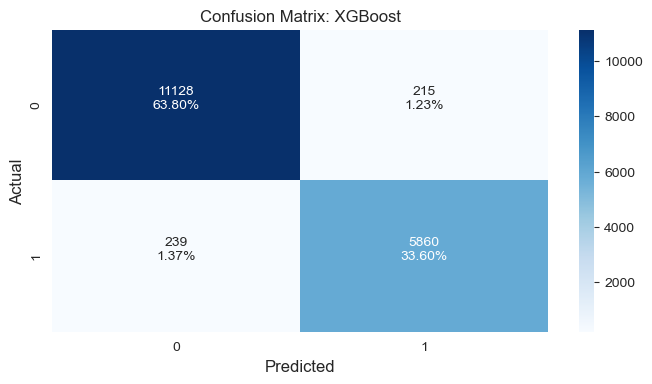

In [14]:
# results: XGBoost
# accuracy
acc = accuracy_score(y_test, y_pred)
# results['XGBoost'].append(acc)
print('accuracy', acc)

# recall
recall = recall_score(y_test, y_pred)
# results['XGBoost'].append(recall)
print('recall', recall)

# f1 score
f1 = f1_score(y_test, y_pred)
# results['XGBoost'].append(f1)
print('f1-score', f1)

# roc_auc
roc = roc_auc_score(y_test, y_pred)
# results['XGBoost'].append(roc)
print('roc_auc', roc)

# class label-wise f1 score
# 0 - Not Phishing
# 1 - Phishing
display(pd.DataFrame(np.asarray(f1_score(y_test, y_pred, average=None)).T, columns=['F1 Score'], index=['0', '1']))

# confusion matrix
# plot heatmap
plot_confusion_matrix(
    confusion_matrix(y_test.values.ravel(), y_pred),
    'Confusion Matrix: XGBoost'
)